In [27]:
import sys
import os

# Переход в корневую директорию проекта
project_root = os.path.abspath("..")  # Выход из папки notebooks
sys.path.append(project_root)




In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from db_init import SessionLocal, engine
from tables import AnimeInfo, AnimeRatings
from catboost import CatBoostRegressor
session = SessionLocal()


In [29]:

def batch_load_sql(query) -> pd.DataFrame:
    CHUNKSIZE = 200000
    conn = engine.connect().execution_options(stream_results=True)
    chunks = []
    for chunk_dataframe in pd.read_sql(str(query.statement), conn, chunksize=CHUNKSIZE):
        chunks.append(chunk_dataframe)
    conn.close()
    return pd.concat(chunks, ignore_index=True)

In [30]:

query_anime_info = session.query(AnimeInfo)
query_anime_ratings = session.query(AnimeRatings)
df_anime_ratings = batch_load_sql(query_anime_ratings)

df_anime_info = batch_load_sql(query_anime_info)
df_anime_ratings = batch_load_sql(query_anime_ratings)




In [31]:
df_anime_ratings.columns

Index(['User_ID', 'Anime_ID', 'Feedback'], dtype='object')

In [32]:
df_anime_info.columns

Index(['anime_ids', 'name', 'genre', 'type', 'episodes', 'rating', 'members'], dtype='object')

In [33]:
df_merged = pd.merge(
    df_anime_ratings,
    df_anime_info,
    left_on="Anime_ID",
    right_on="anime_ids",
    how="left",
)
df_merged = df_merged.drop(columns = 'anime_ids')

In [34]:
df_merged.isna().sum()

User_ID     0
Anime_ID    0
Feedback    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

In [35]:
df_merged.columns

Index(['User_ID', 'Anime_ID', 'Feedback', 'name', 'genre', 'type', 'episodes',
       'rating', 'members'],
      dtype='object')

In [36]:
df_merged['genre'] = df_merged['genre'].str.split(', ')


In [37]:
df_merged.explode('genre')['genre'].value_counts()


genre
Comedy           208247
Action           177319
Romance          134575
Drama            114345
Fantasy          108720
Supernatural     107767
School           102035
Shounen          101006
Adventure         90375
Sci-Fi            86772
Slice of Life     59244
Ecchi             50194
Mystery           49286
Super Power       42561
Magic             41257
Seinen            41118
Harem             40433
Psychological     31653
Mecha             30360
Shoujo            26268
Horror            24028
Military          23938
Historical        20105
Thriller          19803
Demons            18149
Parody            14875
Martial Arts      13840
Sports            12960
Vampire           12409
Game              11900
Music             10741
Space              9624
Police             8855
Kids               6660
Samurai            6358
Hentai             5244
Josei              4033
Dementia           3599
Shoujo Ai          3536
Shounen Ai         3161
Yaoi               1607
Cars      

In [38]:
import seaborn as sns

In [39]:
df_merged.groupby('Anime_ID')


In [40]:
df_anime_ratings['Feedback'].value_counts()

Feedback
8     108782
7      91136
9      83242
10     62557
6      42433
5      19077
4       6847
3       2889
2       1702
1       1278
Name: count, dtype: int64

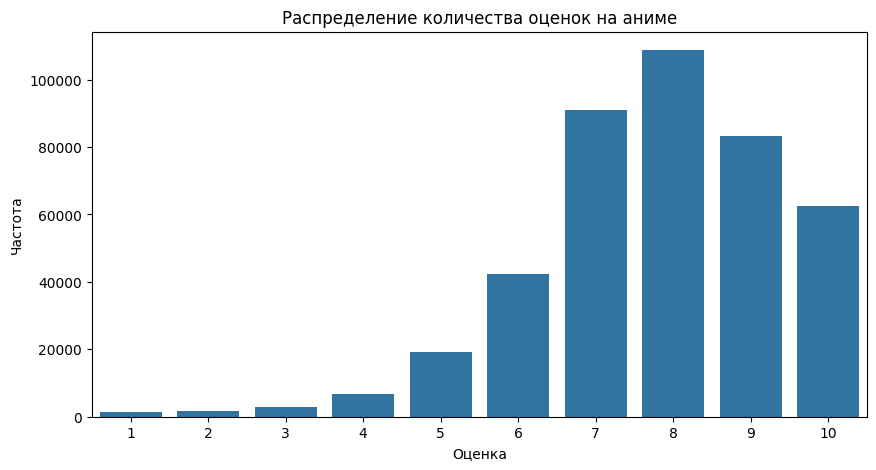

In [41]:
plt.figure(figsize=(10, 5))
sns.barplot(df_anime_ratings['Feedback'].value_counts())
plt.xlabel('Оценка')
plt.ylabel('Частота')
plt.title('Распределение количества оценок на аниме') # Логарифмическая шкала для удобства
plt.show()


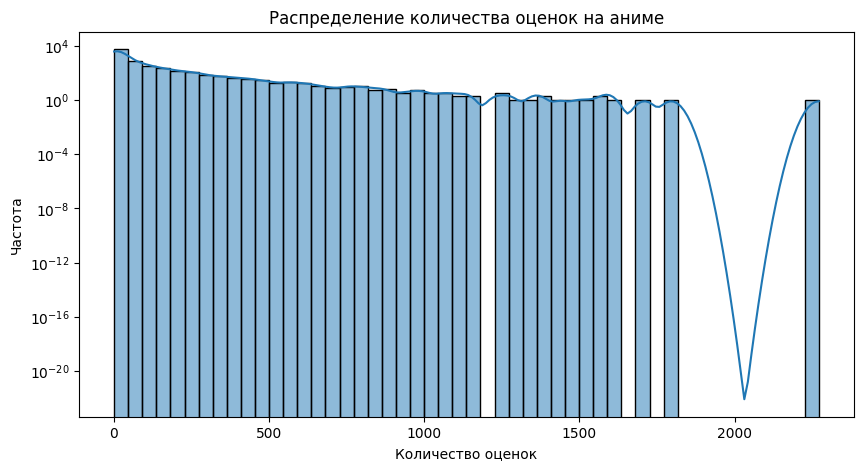

In [42]:
anime_feedback_counts = df_merged['Anime_ID'].value_counts()
plt.figure(figsize=(10, 5))
sns.histplot(anime_feedback_counts, bins=50, kde=True)
plt.xlabel('Количество оценок')
plt.ylabel('Частота')
plt.title('Распределение количества оценок на аниме')
plt.yscale('log')  # Логарифмическая шкала для удобства
plt.show()

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

df_merged["genre_str"] = df_merged["genre"].apply(lambda x: " ".join(x) if isinstance(x, list) else "")
vectorizer = TfidfVectorizer()
genre_tfidf = vectorizer.fit_transform(df_merged["genre_str"])

# Преобразуем в DataFrame
genre_tfidf_df = pd.DataFrame(genre_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

# Добавляем к основному датасету
df_merged = pd.concat([df_merged, genre_tfidf_df], axis=1).drop(columns=["genre", "genre_str"])


In [44]:
df_merged["Liked"] = (df_merged["Feedback"] >= 7).astype(int)
df_merged["type"] = df_merged["type"].astype("category")


In [45]:
df_merged["members_log"] = np.log1p(df_merged["members"])
df_merged = df_merged.drop(columns=["members"])


In [46]:
def hit_rate_at_k(model, test, train, df, k=5):
    hits = 0
    total_users = test["User_ID"].nunique()

    for user in test["User_ID"].unique():
        actual_anime = test.loc[test["User_ID"] == user, "Anime_ID"].values[0]

        # Находим аниме, которые пользователь не смотрел
        watched_anime = train.loc[train["User_ID"] == user, "Anime_ID"].unique()
        candidates = df[~df["Anime_ID"].isin(watched_anime)].copy()

        # Делаем предсказания
        preds = model.predict_proba(candidates[features])[:, 1]  # Вероятность "Liked"
        candidates["score"] = preds

        # Берем топ-K рекомендаций
        top_k = candidates.nlargest(k, "score")["Anime_ID"].values

        # Проверяем, попало ли реальное аниме в топ-K
        if actual_anime in top_k:
            hits += 1

    return hits / total_users  # Доля успешных рекомендаций

# Считаем





In [54]:
from sklearn.model_selection import train_test_split

# Группируем по пользователям и выбираем 1 случайную оценку в тест
test = df_merged.groupby("User_ID").sample(n=1)

# Все остальные оценки - train
train = df_merged.drop(test.index)

# Проверяем размеры
print(f"Train size: {train.shape}, Test size: {test.shape}")


Train size: (415229, 56), Test size: (4714, 56)


In [49]:
# Выбираем фичи и таргет
features = ["User_ID", "Anime_ID", "type", "rating", "episodes", "members_log"] + list(genre_tfidf_df.columns)
target = "Liked"

# Разделяем данные
X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

# Категориальные переменные
cat_features = ["User_ID", "Anime_ID", "type"]


In [50]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=500,  # Количество деревьев
    learning_rate=0.01,  # Скорость обучения
    depth=4,  # Глубина деревьев
    cat_features=cat_features,  # Категориальные фичи
    loss_function="Logloss",  # Классификация
    eval_metric="AUC",  # Оцениваем по AUC
    verbose=100
)

# Обучаем
model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)



0:	test: 0.7183394	best: 0.7183394 (0)	total: 179ms	remaining: 1m 29s
100:	test: 0.8401114	best: 0.8401114 (100)	total: 16.8s	remaining: 1m 6s
200:	test: 0.8432769	best: 0.8432952 (199)	total: 34.2s	remaining: 50.9s
300:	test: 0.8452468	best: 0.8452490 (299)	total: 52.1s	remaining: 34.5s
400:	test: 0.8464661	best: 0.8464688 (399)	total: 1m 10s	remaining: 17.4s
499:	test: 0.8470444	best: 0.8470600 (494)	total: 1m 27s	remaining: 0us

bestTest = 0.8470599617
bestIteration = 494

Shrink model to first 495 iterations.


CatBoostError: (Error 2: No such file or directory) util/system/file.cpp:936: can't open "models/catboost_recommender.cbm" with mode WrOnly|CreateAlways|Seq (0x00000034)

In [51]:
model.save_model("../models/catboost_recommender.cbm")

In [52]:
# Считаем
hit_rate = hit_rate_at_k(model, test, train, df_merged, k=5)
print(f"HitRate@5: {hit_rate:.4f}")

HitRate@5: 0.0017
